# K6 diUbi solvent-PRE with XPLOR-NIH

<center><img src='K6_diUbi_cluster_0_AA.png', width=500></center>

In [1]:
import mdtraj as md
import numpy as np
import pandas as pd
import encodermap as em
import seaborn as sns
import encodermap as em
import tensorflow as tf
import loading_lizard as ll
import matplotlib as mpl
import nglview as ngl
import matplotlib.pyplot as plt
import simtk.openmm.app as app
import simtk.openmm as mm
from custom_gromacstopfile import CustomGromacsTopFile
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import glob, os, re, sys, copy, pickle, itertools

%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from tempfile import gettempdir
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import biotite
import biotite.structure as struc
import biotite.structure.io.mmtf as mmtf
import biotite.sequence as seq
import biotite.sequence.graphics as graphics
import biotite.sequence.io.genbank as gb
import biotite.database.rcsb as rcsb
import biotite.database.entrez as entrez
import biotite.application.dssp as dssp

class HelixPlotter(graphics.FeaturePlotter):

    def __init__(self):
        pass

    # Check whether this class is applicable for drawing a feature
    def matches(self, feature):
        if feature.key == "SecStr":
            if "sec_str_type" in feature.qual:
                if feature.qual["sec_str_type"] == "helix":
                    return True
        return False

    # The drawing function itself
    def draw(self, axes, feature, bbox, loc, style_param):
        # Approx. 1 turn per 3.6 residues to resemble natural helix
        n_turns = np.ceil((loc.last - loc.first + 1) / 3.6)
        x_val = np.linspace(0, n_turns * 2*np.pi, 100)
        # Curve ranges from 0.3 to 0.7
        y_val = (-0.4*np.sin(x_val) + 1) / 2

        # Transform values for correct location in feature map
        x_val *= bbox.width / (n_turns * 2*np.pi)
        x_val += bbox.x0
        y_val *= bbox.height
        y_val += bbox.y0

        # Draw white background to overlay the guiding line
        background = Rectangle(
            bbox.p0, bbox.width, bbox.height, color="white", linewidth=0
        )
        axes.add_patch(background)
        axes.plot(
            x_val, y_val, linewidth=2, color=biotite.colors["dimgreen"]
        )


class SheetPlotter(graphics.FeaturePlotter):

    def __init__(self, head_width=0.8, tail_width=0.5):
        self._head_width = head_width
        self._tail_width = tail_width


    def matches(self, feature):
        if feature.key == "SecStr":
            if "sec_str_type" in feature.qual:
                if feature.qual["sec_str_type"] == "sheet":
                    return True
        return False

    def draw(self, axes, feature, bbox, loc, style_param):
        x = bbox.x0
        y = bbox.y0 + bbox.height/2
        dx = bbox.width
        dy = 0

        if  loc.defect & seq.Location.Defect.MISS_RIGHT:
            # If the feature extends into the prevoius or next line
            # do not draw an arrow head
            draw_head = False
        else:
            draw_head = True

        axes.add_patch(biotite.AdaptiveFancyArrow(
            x, y, dx, dy,
            self._tail_width*bbox.height, self._head_width*bbox.height,
            # Create head with 90 degrees tip
            # -> head width/length ratio = 1/2
            head_ratio=0.5, draw_head=draw_head,
            color=biotite.colors["orange"], linewidth=0
        ))

# Test our drawing functions with example annotation
ubq_sec_annotation = seq.Annotation([
    seq.Feature("SecStr", [seq.Location(1, 7)], {"sec_str_type" : "sheet"}),
    seq.Feature("SecStr", [seq.Location(10, 17)], {"sec_str_type" : "sheet"}),
    seq.Feature("SecStr", [seq.Location(23, 34)], {"sec_str_type" : "helix"}),
    seq.Feature("SecStr", [seq.Location(40, 45)], {"sec_str_type" : "sheet"}),
    seq.Feature("SecStr", [seq.Location(48, 50)], {"sec_str_type" : "sheet"}),
    seq.Feature("SecStr", [seq.Location(56, 59)], {"sec_str_type" : "helix"}),
    seq.Feature("SecStr", [seq.Location(64, 72)], {"sec_str_type" : "sheet"}),
])

# Measurements

**Question:**

Measurement Unit in Tobias' tables:

```
primary sequence	sPRE	err
	mM\+(-1)s\+(-1)	
Gln2	3.67659401129085	3.49776478934889
Ile3	2.03877683593419	1.24739785462518
```

In [102]:
with open("solventPRE_NMR_data/sPRE values Ubi WT.txt", 'r') as f:
    lines = f.read().splitlines()
    
data = []
    
for file in glob.glob('solventPRE_NMR_data/*.txt'):
    this = {}
    this['name'] = os.path.basename(file).split('.')[0].replace(' ', '_')
    this['labels'] = []
    this['x'] = []
    this['y'] = []
    this['y_err'] = []
    with open(file, 'r') as f:
        lines = f.read().splitlines()
    for i, l in enumerate(lines):
        print(l)
        if 'primary' in l or 'mM' in l:
            continue
        datafields = l.split()
        if len(datafields) == 0:
            continue
        if len(datafields) == 1 or '--' in datafields:
            this['labels'].append(datafields[0])
            this['x'].append(i)
            this['y'].append(0)
            this['y_err'].append(0)
        else:
            this['labels'].append(datafields[0])
            this['x'].append(i)
            this['y'].append(float(datafields[1]))
            this['y_err'].append(float(datafields[2]))
    data.append(this)

primary sequence	sPRE	err
	mM\+(-1)s\+(-1)	
Gln2	3.67659401129085	3.49776478934889
Ile3	2.03877683593419	1.24739785462518
Phe4		
Val5	2.00930109656374	2.94263017846034
Lys6	2.75217278575404	1.10804033122158
Thr7	6.0981182022504		0.785394525309821
Leu8	2.94922624345896	1.53018589439035
Thr9	8.38046508538605	0.855337600823175
Gly10	8.02625180462065	1.10983455459456
Cys11	9.18994290390454	0.526108263580092
Thr12	38.4813515787391	3.99246432461574
Ile13	5.23987677207503	0.677806218970206
Thr14	14.5978450321761	1.49003687189029
Leu15	1.7158794106173		1.41569531954069
Glu16	4.09534649822408	1.04823698215694
Val17	--	--
Glu18	0.257198080915906	0.476745080583255
Pro19	--	--
Ser20	4.02283098479724	0.98979920339698
Asp21	1.56182818280281	0.603355634557718
Thr22	1.56361273588636	0.352468326002917
Ile23	4.15429659951598	2.55627436504554
Glu24	--	--
Asn25	3.69729290361757	0.863622820550461
Val26	0.745695894594367	0.907665308411924
Lys27		
Ala28	1.53062199292568	1.14797943068315
Lys29	0.5944493376443

<IPython.core.display.Javascript object>


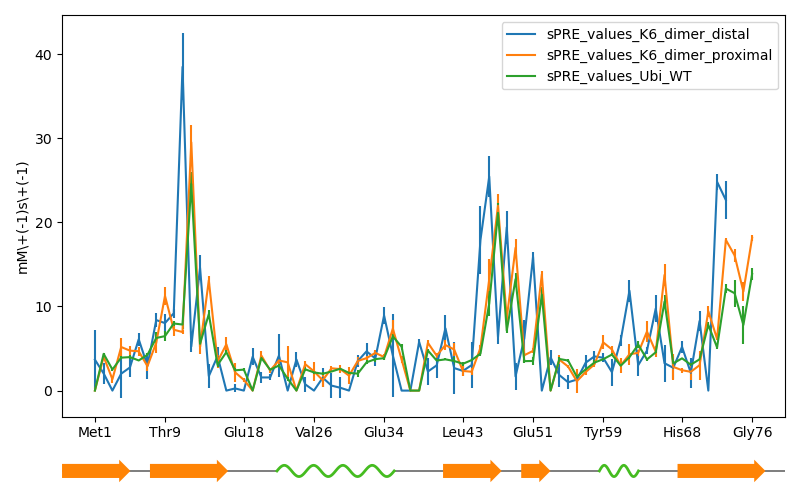

In [228]:
plt.close('all')

fig, ax = plt.subplots(figsize=(8, 5))

for i, d in enumerate(data):
    assert len(d['x']) == len(d['y']) == len(d['y_err'])
    plot = ax.plot(d['x'], d['y'], label=d['name'], color=f'C{i}')
    for x, y, y_err in zip(d['x'], d['y'], d['y_err']):
        ax.errorbar(x=x, y=y, yerr=y_err, color=f'C{i}')
        
ax_divider = make_axes_locatable(ax)
# add an axes above the main axes.
ax2 = ax_divider.append_axes("bottom", size="7%", pad="10%")
graphics.plot_feature_map(
    ax2, ubq_sec_annotation, multi_line=False, loc_range=(1,75),
    # Register our drawing functions
    feature_plotters=[HelixPlotter(), SheetPlotter()]
)
        
xticks = np.array(d['x'])
numElems = 10
idx = np.round(np.linspace(0, len(xticks) - 1, numElems)).astype(int)
ax.set_ylabel("mM\+(-1)s\+(-1)")

ax.set_xticks(xticks[idx])
ax.set_xticklabels(np.array(d['labels'])[idx])
[k.set_linewidth(0) for k in ax2.spines.values()]
ax.legend()
fig.tight_layout()

<IPython.core.display.Javascript object>


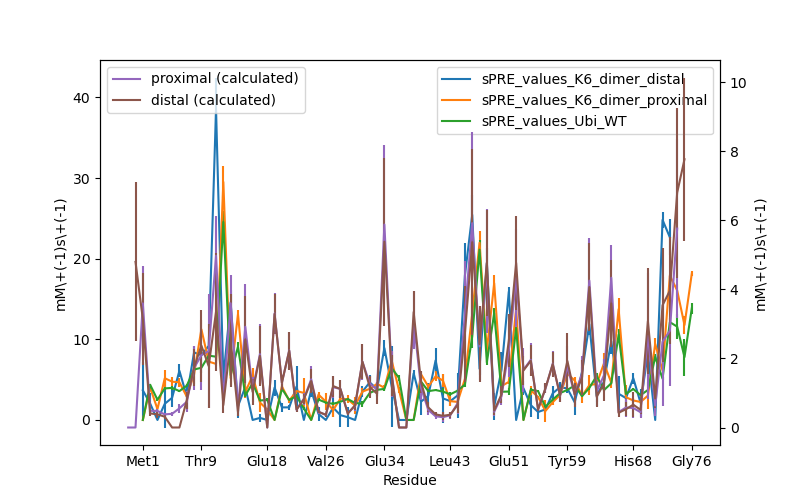

In [218]:
fig, ax = plt.subplots(figsize=(8, 5))

for i, d in enumerate(data):
    assert len(d['x']) == len(d['y']) == len(d['y_err'])
    plot = ax.plot(d['x'], d['y'], label=d['name'], color=f'C{i}')
    for x, y, y_err in zip(d['x'], d['y'], d['y_err']):
        ax.errorbar(x=x, y=y, yerr=y_err, color=f'C{i}')
        
xticks = np.array(d['x'])
numElems = 10
idx = np.round(np.linspace(0, len(xticks) - 1, numElems)).astype(int)
ax.set_xticks(xticks[idx])
ax.set_xticklabels(np.array(d['labels'])[idx])
ax.set_xlabel("Residue")
ax.set_ylabel("mM\+(-1)s\+(-1)")

new_arrs = np.load("all_sPRE_arrays.npy")
means = np.mean(new_arrs, axis=1)
std = np.std(new_arrs, axis=1)

proximal_y = means[:76]
proximal_y_err = std[:76]
distal_y = means[76:]
distal_y_err = std[76:]

ax2 = ax.twinx()

ax2.plot(np.arange(76), proximal_y, label='proximal (calculated)', c='C4')
ax2.plot(np.arange(76) + 1, distal_y, label='distal (calculated)', c='C5')

for x, y, y_err in zip(np.arange(76), proximal_y, proximal_y_err):
    ax2.errorbar(x, y, y_err, c='C4')
    
for x, y, y_err in zip(np.arange(76) + 1, distal_y, distal_y_err):
    ax2.errorbar(x, y, y_err, c='C5')
    
ax2.set_ylabel("mM\+(-1)s\+(-1)")

ax.legend(loc=1)
ax2.legend(loc=2)

# XPLOR-NIH

XPLOR-NIH installation was straightforward. Included is a portable python environment set up to run XPLOR-NIH's python API. Automation done via script:

**PSolPot options:**
```
tauc               - correlation time (default = 0.2)
probeR             - radius of probe molecule (default = 5.4)
probeC             - probe concentration - units? (default = 4.0)
fixTauc            - whether to fix the value of tauc, or to let it float (default = True)
eSpinQuantumNumber - electron sping quantum number (default = 3.5)
domainSelection    - atoms to use in surface calculation (default = 'known and not pseudo')
```

**Further options in script:**

```python
import protocol
radius = 1.4
protocol.loadPDB(pdb_file, deleteUnknownAtoms=True)
from psolPotTools import create_PSolPot

psol = create_PSolPot("psol", file=restraints.tbl)

# options are copied from 
# /xplor-nih/xplor-nih-3.2/python/tests/psolPotTest.py
# This python file runs psolPot on pdb 1D3Z (Ubiquitin)
# Maybe options make sense for diUbi?

# psol options
psol.setRmin(0.8)
#psol.setRadMax(30.0)
#psol.setThkIni(1.0)
#psol.setThkFac(1.4)
#psol.setTcType("fix")
psol.setTauC(0.2)
#psol.setPconc(4.0)
psol.setSqn(3.5)
psol.setRho0(0.24)
psol.setScale(1.7)

psol.tessellation().setVerbose(True)
```

**The restraints.tbl file**

What info does this file contain?
My best guess is, that it contains sPRE experimental data used to refine the given pdb structure via XPLOR-NIH's dynamics:

```python
from ivm import IVM
dyn=IVM()
protocol.torsionTopology(dyn)

protocol.initDynamics(dyn,
                      bathTemp=1000,
                      printInterval=5,
                      numSteps=10,
                      potList=[psol],
                      )

dyn.run()
```

**Contents of restraints.tbl:**

```
assign (resid 2  and name HN)   0.21 0.01
assign (resid 3  and name HN)   0.10 0.01
assign (resid 4  and name HN)   0.09 0.01
assign (resid 5  and name HN)   0.08 0.01
assign (resid 6  and name HN)   0.08 0.01
assign (resid 7  and name HN)   0.12 0.01
assign (resid 8  and name HN)   0.16 0.01
assign (resid 9  and name HN)   0.24 0.01
assign (resid 10 and name HN)   0.33 0.01
assign (resid 11 and name HN)   0.24 0.01
...
```

**What does this mean for us?**

- No dynamics.
- Provided restraints can be whatever.
 - I tried a file full of 0s and one full of 1s and the output did not change.

```
assign (resid 2  and name HN)   0.00 0.01
assign (resid 3  and name HN)   0.00 0.01
assign (resid 4  and name HN)   0.00 0.01
assign (resid 5  and name HN)   0.00 0.01
assign (resid 6  and name HN)   0.00 0.01
assign (resid 7  and name HN)   0.00 0.01
assign (resid 8  and name HN)   0.00 0.01
```

## Avaialable Data

Atomistic Simulations: $0.6 ~\mu s$

CG Simulations: $240 ~\mu s$

<center><img src='martini.png', width=500></center>

In [150]:
ubq_from_pdb = md.load_pdb("https://files.rcsb.org/view/1UBQ.pdb")
ubq_from_pdb = ubq_from_pdb.atom_slice(ubq_from_pdb.top.select("not water"))
residue_names = np.array([r for r in ubq_from_pdb.top.residues] * 2)
psol_pot_base = np.zeros(len(residue_names))
with open("diUbi_empty_spre.tbl", 'r') as f:
    lines = f.readlines()
indices = np.array(list(map(lambda x: int(x.split()[2]), lines)))

raw_data = np.load("all_AA_sPREs_stride_20.npy").T
sPRE_data = arr = np.zeros((len(residue_names), raw_data.shape[1]))
sPRE_data[indices,:] = raw_data
means = np.mean(sPRE_data, axis=1)
std = np.std(sPRE_data, axis=1)

proximal_y = means[:76]
proximal_y_err = std[:76]
distal_y = means[76:]
distal_y_err = std[76:]

<IPython.core.display.Javascript object>


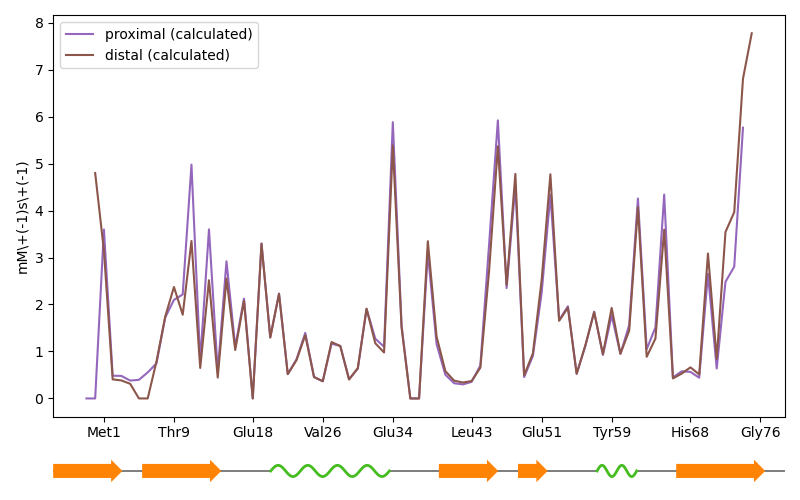

In [229]:
plt.close('all')

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(np.arange(76), proximal_y, label='proximal (calculated)', c='C4')
ax.plot(np.arange(76) + 1, distal_y, label='distal (calculated)', c='C5')
for x, y, y_err in zip(np.arange(76), proximal_y, proximal_y_err):
    ax2.errorbar(x, y, y_err, c='C4')
for x, y, y_err in zip(np.arange(76) + 1, distal_y, distal_y_err):
    ax2.errorbar(x, y, y_err, c='C5')  
ax_divider = make_axes_locatable(ax)
# add an axes above the main axes.
ax2 = ax_divider.append_axes("bottom", size="7%", pad="10%")
graphics.plot_feature_map(
    ax2, ubq_sec_annotation, multi_line=False, loc_range=(1,75),
    # Register our drawing functions
    feature_plotters=[HelixPlotter(), SheetPlotter()]
)     
xticks = np.array(d['x'])
numElems = 10
idx = np.round(np.linspace(0, len(xticks) - 1, numElems)).astype(int)
ax.set_ylabel("mM\+(-1)s\+(-1)")
ax.set_xticks(xticks[idx])
ax.set_xticklabels(np.array(d['labels'])[idx])
[k.set_linewidth(0) for k in ax2.spines.values()]
ax.legend()
fig.tight_layout()

## Differences

How do the calculated values compare to the experimental ones?

For comparison values are normalized into (0, 1) interval.

Maybe parameters for PSolPot need to be changed to make simulations and experiments quantitatively comparable.

<IPython.core.display.Javascript object>


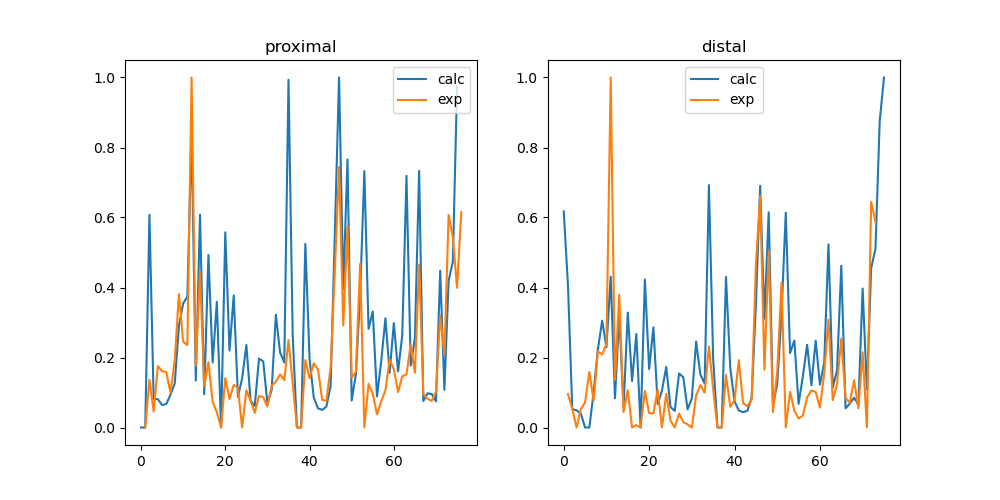

In [231]:
plt.close('all')

fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

proximal_diffs = proximal_y / proximal_y.max() - np.array(data[1]['y']) / np.array(data[1]['y']).max()

ax1.set_title('proximal')
ax1.plot(np.arange(76), proximal_y / proximal_y.max(), label='calc', c='C0')
ax1.plot(np.arange(76) + 1, np.array(data[1]['y']) / np.array(data[1]['y']).max(), label='exp', c='C1')

ax2.set_title('distal')
ax2.plot(np.arange(76), distal_y / distal_y.max(), label='calc', c='C0')
ax2.plot(np.arange(73) + 1, np.array(data[0]['y']) / np.array(data[0]['y']).max(), label='exp', c='C1')

ax1.legend()
ax2.legend()

# Sub-states in conformation space

## Dimensionality Reduction into 5D

Clustering in too-high dimensions is not possible (the curse of dimensionality)

Euclidean distance in higher dimensions increases linearly.
\begin{equation}
d(p, q) = \sqrt{\left( p_1 - q_1 \right)^2 + \left( p_2 - q_2 \right)^2 + \ldots + \left( p_n - q_n \right)^2}
\end{equation}

Volume in higher dimensions increases exponentially.
\begin{equation}
V_{d-dimensional-cube} = d \cdot 2^{d -1 } \cdot \Gamma(d/2)
\end{equation}

In [13]:
# Use OpenMM to load topology due to non-standard isopeptide AAs
gro_file = "/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_01/start.gro"
top_file = "/mnt/scc3/andrejb/ARCHIVE/simulations/2017_04_27_G_2ub_k6_01_01/system.top"

import simtk.openmm.app as app
import simtk.openmm as mm

gro = app.GromacsGroFile(gro_file)
top = CustomGromacsTopFile(top_file, periodicBoxVectors=gro.getPeriodicBoxVectors(), includeDir='/home/andrejb/Research/DEVA/2016_11_27_diub_GROMOS/')
print(top.topology)

('/mnt/scc3/andrejb/ARCHIVE/simulations/2017_04_27_G_2ub_k6_01_01', '/home/andrejb/Research/DEVA/2016_11_27_diub_GROMOS/', '/mnt/scc3/andrejb/ARCHIVE/simulations/2017_04_27_G_2ub_k6_01_01')
('/mnt/scc3/andrejb/ARCHIVE/simulations/2017_04_27_G_2ub_k6_01_01', '/home/andrejb/Research/DEVA/2016_11_27_diub_GROMOS/', '/home/andrejb/Research/DEVA/2016_11_27_diub_GROMOS/./gromos54a7-isop.ff')
('/mnt/scc3/andrejb/ARCHIVE/simulations/2017_04_27_G_2ub_k6_01_01', '/home/andrejb/Research/DEVA/2016_11_27_diub_GROMOS/', '/home/andrejb/Research/DEVA/2016_11_27_diub_GROMOS/./gromos54a7-isop.ff')
('/mnt/scc3/andrejb/ARCHIVE/simulations/2017_04_27_G_2ub_k6_01_01', '/home/andrejb/Research/DEVA/2016_11_27_diub_GROMOS/', '/home/andrejb/Research/DEVA/2016_11_27_diub_GROMOS/./gromos54a7-isop.ff')
('/mnt/scc3/andrejb/ARCHIVE/simulations/2017_04_27_G_2ub_k6_01_01', '/home/andrejb/Research/DEVA/2016_11_27_diub_GROMOS/', '/mnt/scc3/andrejb/ARCHIVE/simulations/2017_04_27_G_2ub_k6_01_01')
('/mnt/scc3/andrejb/ARCHIV

## Use CA distances as  CVs

This results in a very high-dimensional Dataset of 11476 dimensions. We will reduce the dimensionality using ANNs, but to what degree. Surely, if reduced to 2D too much information will be lost.

In [11]:
# top = CustomGromacsTopFile(top_file, periodicBoxVectors=gro.getPeriodicBoxVectors(), includeDir='/home/andrejb/Research/DEVA/2016_11_27_diub_GROMOS/')

traj = md.load("2017_04_27_G_2ub_k6_01_01_traj_nojump_correct_topology.h5")
CA_indices = traj.top.select("name CA")
CA_indices = np.array(list(itertools.combinations(CA_indices, 2)))
print(CA_indices.shape)

(11476, 2)


## Decide on the lowd Dimensionality

In [21]:
# load pairwise distances of all trajs
distances = np.load("Ubi_K6_CA_pairwise_distances.npy")[::5]
print(distances.shape)

(12003, 11476)


**Information loss of first 18 dimensions doing PCA.**

In [33]:
X = distances[:,:18]
print('data shape:', X.shape)

from sklearn.preprocessing import StandardScaler
# on this distribution. 
sc = StandardScaler()
X_std =  sc.fit_transform(X)

cov_matrix = np.cov(X_std.T)
print("cov_matrix shape:",cov_matrix.shape)

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

data shape: (12003, 18)
cov_matrix shape: (18, 18)


**Sort Eigenvalues**

In [36]:
# Make a set of (eigenvalue, eigenvector) pairs:
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]
# Sort the (eigenvalue, eigenvector) pairs from highest to lowest with respect to eigenvalue
eig_pairs.sort()
eig_pairs.reverse()
# Extract the descending ordered eigenvalues and eigenvectors
eigvalues_sorted = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sorted = [eig_pairs[index][1] for index in range(len(eigenvalues))]

**Variance in percentages**

In [37]:
tot = sum(eigenvalues)
var_explained = [(i / tot) for i in sorted(eigenvalues, reverse=True)]  # an array of variance explained by each 
# eigen vector... there will be 18 entries as there are 18 eigen vectors)
cum_var_exp = np.cumsum(var_explained)  # an array of cumulative variance. There will be 18 entries with 18 th entry 
# cumulative reaching almost 100%

**Plot**

Conclusion: The first 10 principal components allow to capture approx. 90% of information.
However, Clustering in 10 Dimensions would still suffer from the curse of dimensionality. Arbitrarily, I will choose 5 as the number of bottleneck dimensions.

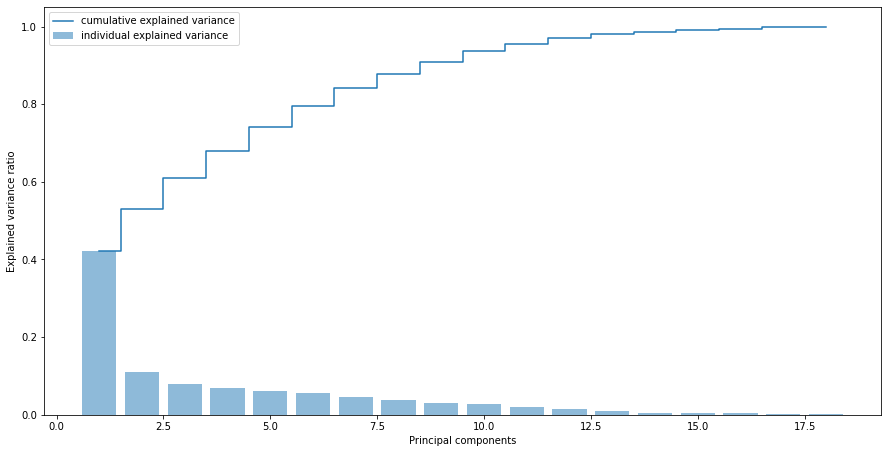

In [42]:
plt.bar(range(1,19), var_explained, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,19),cum_var_exp, where= 'mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc = 'best')
fig = plt.gcf()
fig.set_size_inches(15, 7.5)
plt.show()

# Using NNs for dimensionality reduction

<center><img src='nn_autoencoder_architecture.png', width=500></center>

# Using HDBSCAN for clustering

In [203]:
lowd = np.load('atomistic_lowd.npy')
clusterer_labels = np.load('clusterer_AA_labels.npy')
np.unique(clusterer_labels)
color_palette = sns.color_palette('deep', clusterer_labels.max() + 1)
cluster_colors = [(*color_palette[x], 1) if x >= 1
                  else (0, 0, 0, 0) if x == 0
                  else (0.5, 0.5, 0.5, 0.05)
                  for x in clusterer_labels]

<IPython.core.display.Javascript object>


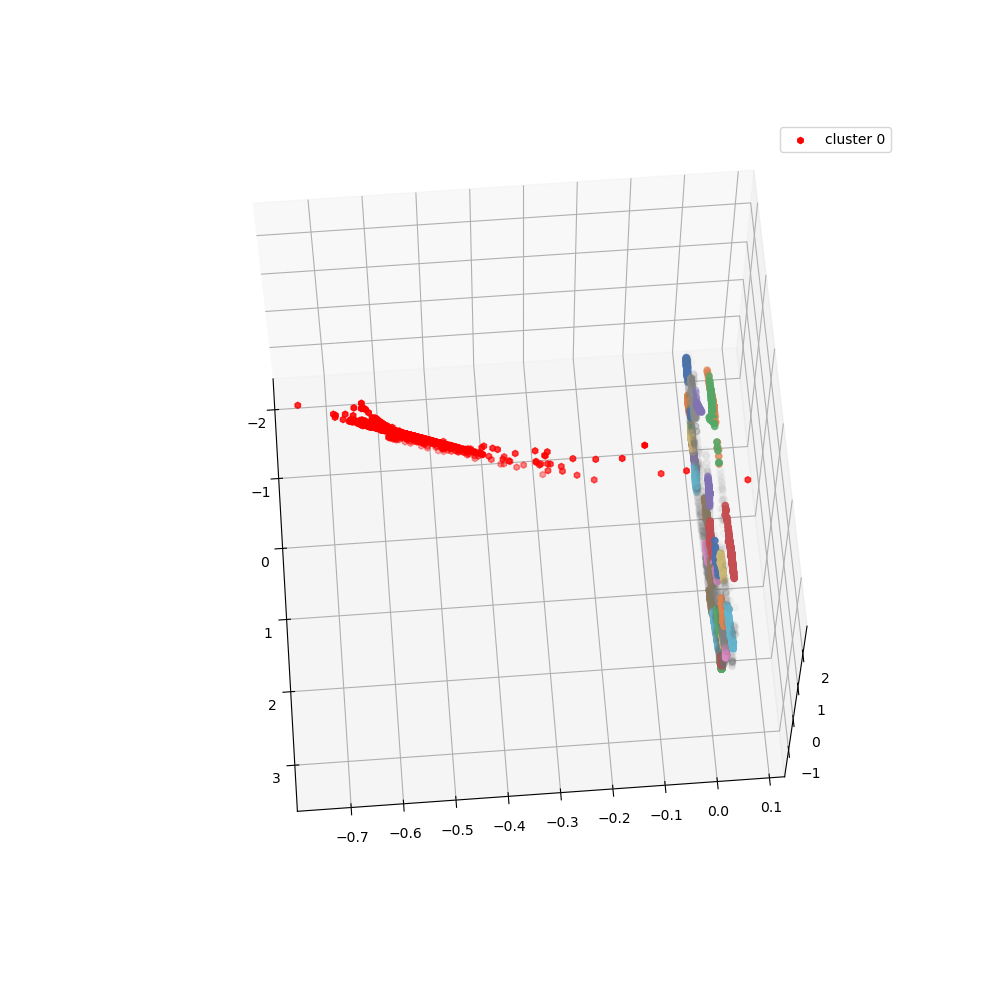

In [236]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*lowd[::5,2:5].T, c=cluster_colors[::5])
where = np.where(clusterer_labels == 0)[0]
ax.scatter(*lowd[where,:3].T, c='red', marker='h', label='cluster 0')
ax.legend()

# Example: Cluster 0

http://134.34.112.158/K6_diubi/K6_diUbi_cluster_0_AA.html

In [222]:
# traj = md.load('CA_distances_cluster_trajs/cluster_0/joined.xtc', top='CA_distances_cluster_trajs/cluster_0/cluster_0_frame_0.pdb')
# for i, frame in enumerate(traj):
#     if i == 0:
#         traj_out = frame
#     else:
#         traj_out = traj_out.stack(frame)
view = ngl.show_mdtraj(traj_out)
view

NGLWidget()

<IPython.core.display.Javascript object>


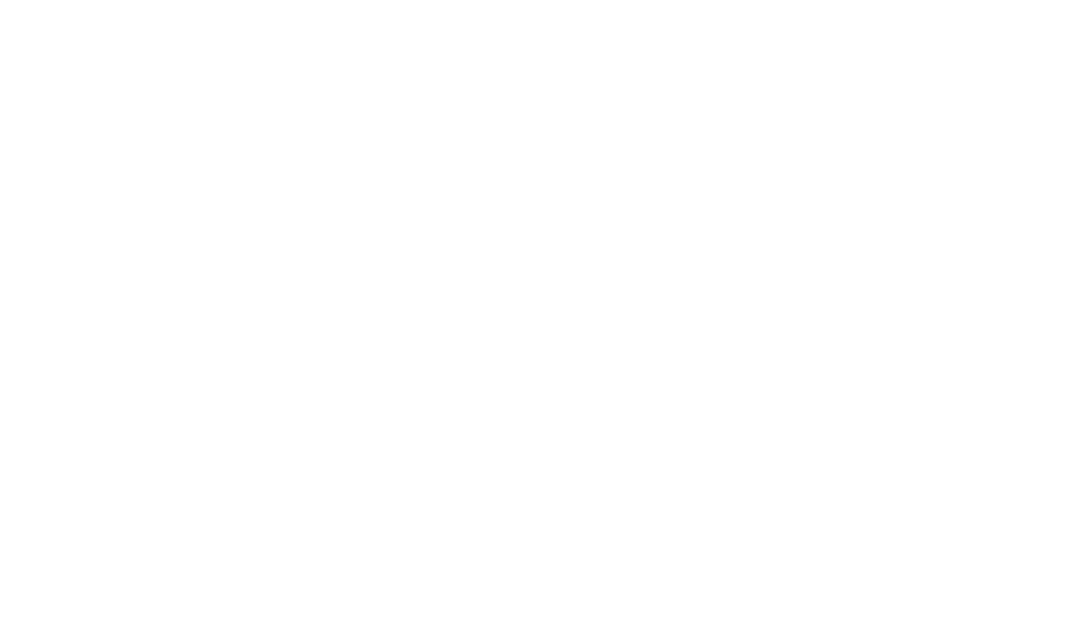

In [233]:
plt.close('all')

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(np.arange(76), proximal_y[:100], label='cluster 0 proximal', c='C0')
ax.plot(np.arange(76) + 1, distal_y[:100], label='cluster 0 distal', c='C1')

for x, y, y_err in zip(np.arange(76), proximal_y[:100], proximal_y_err[:100]):
    ax2.errorbar(x, y, y_err, c='C4')
    
for x, y, y_err in zip(np.arange(76) + 1, distal_y[:100], distal_y_err[:100]):
    ax2.errorbar(x, y, y_err, c='C5')
    
ax_divider = make_axes_locatable(ax)
# add an axes above the main axes.
ax2 = ax_divider.append_axes("bottom", size="7%", pad="10%")
graphics.plot_feature_map(
    ax2, ubq_sec_annotation, multi_line=False, loc_range=(1,75),
    # Register our drawing functions
    feature_plotters=[HelixPlotter(), SheetPlotter()]
)
        
xticks = np.array(d['x'])
numElems = 10
idx = np.round(np.linspace(0, len(xticks) - 1, numElems)).astype(int)
ax.set_ylabel("mM\+(-1)s\+(-1)")

ax.set_xticks(xticks[idx])
ax.set_xticklabels(np.array(d['labels'])[idx])
[k.set_linewidth(0) for k in ax2.spines.values()]
ax.legend()
fig.tight_layout()

# 2nd meeting.

## CG data used:

**Time of 240.760992 $\mu s$**

In [7]:
trajs = em.Info_all(sims_trajs, tops=sims_pdbs[0], common_str=['k6'])
trajs.load_trajs()

In [11]:
print(sum([t.time[-1] for t in trajs]) / 1000 / 1000)

0.761
